# Objective

- Tokenizers - Under the hood
- Embedding models for classical NLP tasks

# Setup

In [1]:
! pip install -q gensim==4.3.3 tiktoken==0.7.0

In [2]:
import string
import nltk
import re
import tiktoken
import gensim

import numpy as np
import pandas as pd

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from gensim.models.keyedvectors import load_word2vec_format

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

2024-08-26 05:19:17.092131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/studio-lab-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# The Fundamental Problem of NLP

Given an input sequence $s_1$, learn a mapping $f: s_1 \rightarrow s_2$ to an output sequence $s_2$.

Examples:
1. $s_1$: Product Review, $s_2$: Sentiment
2. $s_1$: Meeting Transcript, $s_2$: Summary
3. $s_1$: Context + Question, $s_2$: Answer
4. $s_1$: Sentence in English, $s_2$: Translated sentence in French

Over the next few sessions,we will build increasingly sophisticated models to tackle this fundamental problem of NLP.

# Data

As we build models to illustrate how NLP tasks could be tackled, we need one dataset that we use to compare across methods. For this we use a movie review dataset.

In [5]:
dataset_path = 'labeled_sentiments_data.tsv'

In [6]:
dataset = pd.read_csv(dataset_path, sep='\t')

In [7]:
dataset.sample(5)

,id,sentiment,review
22244,8654_9,1,it's amazing that so many people that i know h...
14231,10102_1,0,If ever there was a film that deserved a big f...
14734,4102_4,0,'Dead Letter Office' is a low-budget film abou...
9705,2050_2,0,"Not that \a film by Ulli Lommel\"" filled me wi..."
4058,6197_10,1,Fay Grim is a true example of what I call a co...


In [8]:
dataset.sentiment.value_counts()

sentiment
1    12500
0    12500
Name: count, dtype: int64

# Clean Corpus

Document: A sample piece of text that is used as the input sequence.

Corpus: A collection of all the documents in the dataset. 

One aspect of data preparation for NLP is to clean specific nuances in the corpus that are not relevant to the task. One such example is lemmatization, where the objective is to clean the words in the reviews reducing variations of the word (for e.g., its plurals to the root word).

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
wordnet_map = {
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "J": wordnet.ADJ,
    "R": wordnet.ADV
}

In [11]:
def clean_text(text):
    # Lowercase text
    text = text.lower()
    # Remove html tags
    text = re.sub('<[^<]+?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove urls
    text = re.sub(r"https?://\S+|www\.\S+", "", text )
    # Remove digits
    text = re.sub(r'[0-9]', ' ', text)
    # Lemmatize text
    pos_tagged_text = nltk.pos_tag(text.split())
    text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
    # Remove every thing other than space, word and hash
    text = re.sub(r'[^\w\s]',' ',text)
    # Replace symbols by space in text
    text = re.sub(' +', ' ', text)

    return text

In [12]:
dataset.review[0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [13]:
clean_text(dataset.review[0])

'with all this stuff go down at the moment with mj ive start listen to his music watch the odd documentary here and there watch the wiz and watch moonwalker again maybe i just want to get a certain insight into this guy who i think be really cool in the eighty just to maybe make up my mind whether he be guilty or innocent moonwalker be part biography part feature film which i remember go to see at the cinema when it be originally release some of it have subtle message about mjs feeling towards the press and also the obvious message of drug be bad mkayvisually impressive but of course this be all about michael jackson so unless you remotely like mj in anyway then you be go to hate this and find it bore some may call mj an egotist for consent to the making of this movie but mj and most of his fan would say that he make it for the fan which if true be really nice of himthe actual feature film bit when it finally start be only on for minute or so exclude the smooth criminal sequence and jo

Let us take a deeper look at how the lemmatizer is working. To illustrate, let us look at the first 10 words of the first review. 

In [16]:
nltk.pos_tag(dataset.review[0].split()[0:10])

[('With', 'IN'),
 ('all', 'PDT'),
 ('this', 'DT'),
 ('stuff', 'NN'),
 ('going', 'VBG'),
 ('down', 'RP'),
 ('at', 'IN'),
 ('the', 'DT'),
 ('moment', 'NN'),
 ('with', 'IN')]

In the code snippet below, we are running through each word and if the Parts-of-Speech tag of the word is in the wordnet map dictionary above (noun, adverb, adjective or adverb) then it is lemmatized according the grammatical rules of these word types. Else, the word is lemmatized assuming it is a noun.

In [17]:
pos_tagged_text = nltk.pos_tag(dataset.review[0].split()[0:10])
" ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

'With all this stuff go down at the moment with'

We can apply the clean text function defined above to the entire selection of rows like so.

In [14]:
sample_cleaned_corpus = dataset.sample(1000).review.apply(clean_text)

In [15]:
sample_cleaned_corpus.sample(2)

14123    walter matthau and george burn just work so we...
7985     have to be one of the bad waste of mm movie fi...
Name: review, dtype: object

To keep execution times low, we consider 1000 reviews for the rest of the notebook.

# Tokenize

Once a review is cleaned, it needs to be tokenized (i.e., split into atomic units of information). One method to do this is to use a word level tokenizer.

In [18]:
sample_sentence = "this movie be so badly write direct and act"

In [19]:
word_tokenizer = RegexpTokenizer(r'\w+')

In [20]:
word_tokenizer.tokenize(sample_sentence)

['this', 'movie', 'be', 'so', 'badly', 'write', 'direct', 'and', 'act']

Word-level tokenization is not the only method to tokenize text. For example, modern LLMs tokenize input text using an algorithm called byte-pair encoding (BPE). Cleaning text before tokenization reduces the size of the vocabulary that we have to deal with.

In [22]:
gpt4_tokenizer = tiktoken.encoding_for_model("gpt-4")
[gpt4_tokenizer.decode([token]) for token in gpt4_tokenizer.encode(sample_sentence)]

['this', ' movie', ' be', ' so', ' badly', ' write', ' direct', ' and', ' act']

In [23]:
token_list = [word_tokenizer.tokenize(cleaned_review) for cleaned_review in sample_cleaned_corpus]

In [24]:
len(token_list)

1000

In [25]:
# unnest the lists and remove duplicates
vocabulary = set(x for lst in token_list for x in lst)

In [26]:
len(vocabulary)

17577

As indicated in the above output, we have a vocabulary of 17,577 words in the reviews corpus. In order to map these reviews to a sentiment, we need to create a rich feature representation that can then be used by classification models (e.g., logistic regression, SVM) for sentiment assignment. 

Let us look at some naive methods to create features from the reviews.

# Featurization & Embeddings

## Sparse Embeddings (Bag-of-Words)

One method to describe the review content is to simply use all the words in the vocabulary as the features and use a one-hot flag to indicate whether a word was present or absent in the corpus. This ensures that the content of each review is accurately captured as counts. A count vectorizer accomplishes exactly this. It creates columns = number of words in the vocabulary and for a given document, if a word exists in the document, a flag of 1 is assigned, else 0 is assigned. This approach is called a bag of words approach since we are essentially taking all the words together but not necessarily considering their context or their order. We simply throw all the words in the vocabulary bag and flag whether a specific word is present in the document or not.  

**Count Vectorizer**

Count vectorizers count the number of times each word in vocabulary appears in each document.

In [27]:
count_vectorizer = CountVectorizer()

In [28]:
sample_cleaned_corpus.shape

(1000,)

We start with 1000 reviews (hence the shape (1000, ) indicating 1000 strings.

In [29]:
feature_vectors = count_vectorizer.fit_transform(sample_cleaned_corpus)

In [30]:
feature_vectors.shape

(1000, 17551)

Once the reviews pass through the vectorized, with the `fit_transform` method, we get an output shape of `(1000, 17551)`. This can be thought of as representing each of the 1000 documents in a 17551 dimensional vocabulary space.

The problem however is that this is a very sparse representation that mostly contains 0's (as indicated by the below output).

In [31]:
feature_vectors[0:2].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
feature_vectors[0:5].toarray()[:, 0:50]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

We can inspect the column names of the output matrix by using the `get_feature_names_out` method of the count vectorizer like so:

In [31]:
count_vectorizer.get_feature_names_out()

array(['aaaugh', 'aag', 'aames', ..., 'zunz', 'åmål', 'émigré'],
      dtype=object)

Why is the number of columns in the output not matching the vocabulary size we observed in the last section? This is because of the difference in the tokenizer used. We can pass in our choice of tokenizers as in the following code snippet.

In [32]:
count_vectorizer = CountVectorizer(tokenizer=word_tokenizer.tokenize)
feature_vectors = count_vectorizer.fit_transform(sample_cleaned_corpus)
feature_vectors.shape

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1000, 17577)

**TF-IDF Vectorizer**

An improvement over the count vectorizer is the TF-IDF vectorizer that accounts not only for the count of a specific word in the document (i.e., its term frequency, TF) but also its broader occurence in the corpus using an IDF score.

$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$, and the idf is computed as $\text{idf}(t) = \log\big(\dfrac{n}{\text{df}(t)}\big) + 1$. Where $n$ is the total number of documents in the document set and df$(t)$ is the document frequency of $t$.

The idea of an IDF score is that terms that appear frequently in all documents (e.g., a, an, the) have little to offer beyond their grammatical contribution to the NLP task and hence should be given lesser weight compared to rare words. From the formula above, we note that idf$(t)$ is exactly 1 when the df$(t) = n$, that is when a term appears in all the $n$ documents. In contrast if a word appears only once in the entire corpus, then its idf score would be $log(n) + 1$.

In [33]:
tfidf_vectorizer = TfidfVectorizer()

In [34]:
feature_vectors = tfidf_vectorizer.fit_transform(sample_cleaned_corpus)

In [35]:
feature_vectors.shape

(1000, 17551)

In [36]:
feature_vectors[0:5].toarray()[:, 0:50]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.12796657, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03352143, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0. 

One issue with these vectorizers is that they cannot handle out of vocabulary documents.

In [38]:
tfidf_vectorizer.transform(['Tesla']).toarray().sum()

0.0

## Dense Embeddings

A better approach than sparse representations is to create dense embeddings that capture the meaning of the words in the documents in a space that allows for such meaning to be learnt. An *embedding* is a vector of numbers associated with each word in a sample that captures both the semantics of the word as well as its linguistic information. In the embedding space, words of similar meaning are close to each other. We treat the dimension of these embeddings as a hyperparameter that we tune according to a downstream task (e.g., sentiment analysis).

The word2vec method of learning word embeddings starts by defining a sliding context window size $w$ and a hidden layer dimension ($d_h$) to which the words in the window would be projected to (see figures below).

In order to learn the embeddings of each word, we define two objectives:
- SkipGram where given the center word in the window, we predict the rest of the context words. 
- Continuous Bag of Words (CBOW) where given the context words in the window, we predict the center word.

For both variations of word2vec (skipgram and cbow), we use a one hidden layer (of dimension $d_h$) neural network to make these predictions.

Empirically, skipgram is observed to create better embeddings. 

**Word2Vec - SkipGram**

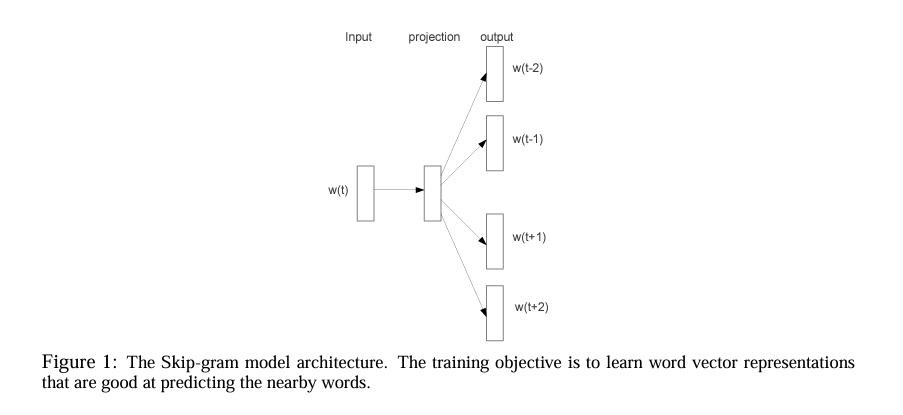

(Source: https://arxiv.org/pdf/1310.4546)

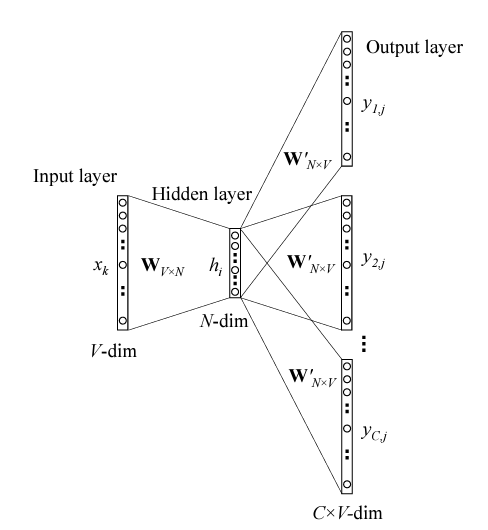

(Source: https://arxiv.org/pdf/1411.2738)

As indicated in the above figure, for skipgram, we essentially learn two matrices - $W_{V \times d_h}$ and $W^\prime_{d_h \times V}$. $W_{V \times d_h}$ projects the input word (center word) that is a one-hot encoded word in the vocabulary space into an embedding dimension ($d_h$) space. $W^\prime_{d_h \times V}$ then projects this representation back to the vocabulary space where a pairwise comparision can be made with the context words as ground truth. We compute the average log loss for the entire corpus, sliding the context window and backpropogate to learn the weights in the two matrices -  $W_{V \times d_h}$ and $W^\prime_{d_h \times V}$. $W_{V \times d_h}$. 

In [39]:
skipgram_embedding_model = gensim.models.Word2Vec(
    sentences=token_list, vector_size=9, window=5, min_count=1, sg=1,
    epochs=5
)

In [40]:
skipgram_embedding_model.wv['movie']

array([-0.8233581 ,  0.05817042,  2.2201815 , -0.6912606 ,  0.4290824 ,
        0.903944  , -0.21755564, -0.28484672,  0.9153383 ], dtype=float32)

As discussed before, these vectors are called embeddings because they *embed* a word in a high dimensional space.

This method of creating embeddings scales even when we receive new documents in the corpus or when we want to train the model further. To resume training from a specific saved checkpoint, we update the vocabulary accounting for any new words that were generated and resume training.

In [44]:
skipgram_embedding_model.build_vocab(token_list, update=True)

In [45]:
skipgram_embedding_model.train(
    token_list,
    total_examples=len(token_list),
    epochs=10
)

(1622079, 2224450)

In [46]:
skipgram_embedding_model.wv['movie']

array([-0.60605925,  0.34402364,  1.5479271 , -0.50289786,  0.25543222,
        0.8022247 , -0.01810802, -0.38225806,  0.71381915], dtype=float32)

**Word2Vec - CBOW**

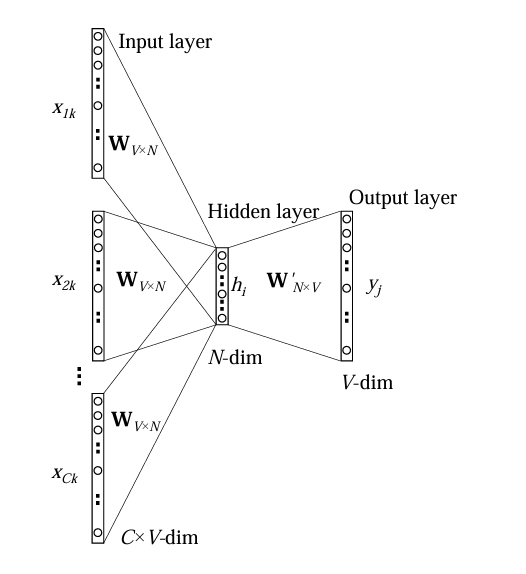

(Source: https://arxiv.org/pdf/1411.2738)

In CBOW we average the embeddings that come from projections of the context words with $W_{V \times d_h}$ and project this averaged embedding back to the vocabulary space using $W^\prime_{d_h \times V}$. $W_{V \times d_h}$ to compare it with the ground truth (i.e., the center word). This comparison yields a log loss for the samples created through the sliding context window that we can backpropogate to learn the weights of the matrices - $W_{V \times d_h}$ and $W^\prime_{d_h \times V}$. $W_{V \times d_h}$.

In [47]:
cbow_embedding_model = gensim.models.Word2Vec(
    sentences=token_list, vector_size=100, window=5, min_count=1, sg=0,
    epochs=5
)

In [48]:
cbow_embedding_model.wv['movie']

array([ 1.2802266e-01,  6.0893571e-01,  8.4170952e-02, -7.0108950e-01,
        5.6387782e-01, -1.5861182e+00,  6.3405222e-01,  2.0781817e+00,
       -1.3132923e+00, -1.1735042e+00, -4.9052256e-01, -1.6053953e+00,
       -3.0559969e-01,  5.9676409e-01,  5.8030373e-01, -6.3259590e-01,
        9.6227634e-01, -2.4768810e-01, -7.8392351e-01, -2.7901874e+00,
        1.0175228e+00, -7.0876554e-02,  1.2303958e+00, -1.1834338e+00,
       -2.6092625e-01,  4.9365494e-02, -1.2552574e+00, -1.9066414e-02,
       -1.0468507e+00,  4.8032004e-01,  1.4856871e+00,  1.7768839e-01,
        4.8776412e-01, -1.1446513e+00, -3.3797771e-01,  2.6524806e-01,
       -9.5793389e-02, -6.5865612e-01, -1.5454781e-01, -8.1191748e-01,
        4.6230704e-01, -8.7472063e-01, -7.0023429e-01, -3.6295649e-02,
        1.3788532e-01, -5.0065666e-01, -4.0545133e-01, -4.7784680e-01,
        3.6202797e-01,  3.1791174e-01,  4.4650894e-01, -1.4612560e+00,
        1.3663855e-02,  1.3402948e-02,  1.5838066e-01,  2.5964394e-01,
      

In [49]:
cbow_embedding_model.build_vocab(token_list, update=True)

In [50]:
cbow_embedding_model.train(
    token_list,
    total_examples=len(token_list),
    epochs=10
)

(1622258, 2224450)

In [51]:
cbow_embedding_model.wv['movie']

array([ 0.6727748 ,  0.7333034 , -0.24530864, -1.8078464 ,  0.829908  ,
       -0.58721477, -0.05159629,  0.5683911 , -1.131056  , -0.796506  ,
       -1.0403662 , -0.9011249 , -0.7866047 ,  0.20961775,  1.7724894 ,
       -0.3143995 ,  2.157093  ,  0.93506   , -0.6778236 , -3.134461  ,
        0.74071246, -0.15579444,  1.7402021 , -0.7899464 , -0.6282925 ,
        0.892389  , -1.7323362 ,  0.4673604 , -1.7155195 ,  1.8582187 ,
        1.158554  ,  0.86587214,  1.2435253 , -1.2241385 , -1.0524439 ,
       -0.76186067, -0.9940873 ,  0.19056436,  0.18179782, -0.72083026,
        0.9875254 ,  0.22167411,  0.16142325, -0.3613827 , -1.3866886 ,
       -1.3657883 ,  0.9004116 , -0.72237986, -0.69862366, -0.19593164,
        0.86558795, -1.6536385 , -0.09321816, -0.28001016,  0.55810523,
       -0.14911138,  0.46357495, -0.38736236,  0.5167068 ,  1.3495276 ,
        0.4685498 , -0.08728583,  1.4640362 ,  0.89638454, -0.24724348,
        1.6646208 ,  0.46919948,  0.15557408, -2.013515  ,  1.15

A fundamental limitation of the word2vec method we describe here is that we do not learn the embeddings of out of vocabulary words. For example:

In [52]:
cbow_embedding_model.wv['movieewwwww']

KeyError: "Key 'movieewwwww' not present"

In this case the error shows that since the input word is not in the vocabulary, its embedding cannot be returned.

**FastText**

Fasttext improves on vanilla word2vec by solve for out of vocabulary embeddings through subword embeddings and more efficient training optimizations.

With Fasttext, for each word, we create character level n-grams of certain sizes along with the original words and learn these embeddings using skipgram or cbow.

For example, with a minimum characters of 2 and maximum characters of 3, the word `movie` is expanded into the set - {mo, ov, vi, ie, ..., mov, ovi, vie, ...}. This allows the composition of unknown word embeddings to be recovered from the subword embeddings.

In [54]:
fasttext_embedding_model = gensim.models.FastText(
    vector_size=100,
    window=5,
    min_count=1
)

In [55]:
fasttext_embedding_model.build_vocab(token_list)

In [56]:
fasttext_embedding_model.wv['movie']

array([-3.9527561e-03, -1.5946920e-03, -2.6372257e-03, -1.6989685e-03,
        2.8121208e-03,  5.6125497e-04, -1.6123129e-03,  2.5310488e-03,
        1.5890196e-03, -2.3437650e-03, -5.5439264e-04, -8.6650660e-04,
       -5.8444963e-05,  4.9268722e-04, -1.8073010e-03,  2.8560523e-04,
       -1.1098641e-03,  9.5442671e-04,  3.9012978e-04,  9.3619434e-05,
       -3.9204489e-03, -1.4308967e-03, -3.7809447e-03,  1.0707037e-03,
       -4.9742975e-04,  2.8876972e-03,  4.4412605e-04, -7.8528770e-04,
        1.2103088e-03,  7.7345240e-04, -2.1838218e-03, -1.4174153e-03,
       -1.8811280e-04, -2.0129725e-03, -5.1440392e-04, -1.0306876e-03,
       -7.7087933e-04, -2.0531195e-03,  5.5576456e-05,  1.0889552e-04,
       -7.7192724e-04,  1.6093942e-03, -1.6503321e-03, -6.6798081e-04,
       -2.5693860e-04,  1.3978366e-03,  2.2695160e-03,  6.5249368e-04,
        7.6072308e-04,  1.1027729e-04,  2.8690184e-03, -1.7651344e-04,
        4.7270179e-04, -7.5190008e-04, -5.6632856e-05,  1.5900008e-03,
      

In [57]:
fasttext_embedding_model.train(
    token_list,
    total_examples=len(token_list),
    epochs=10
)

(1622670, 2224450)

In [58]:
fasttext_embedding_model.wv['movie']

array([-0.16114035, -0.95156926, -0.7457381 , -0.8315766 ,  0.54539996,
        1.3549557 , -1.3175948 ,  1.2528304 ,  0.47164682, -0.29831994,
       -0.04387514, -0.17091595, -0.5957832 ,  0.57778573,  0.4328722 ,
       -0.8017698 ,  0.4013737 , -0.01756684,  0.09072692,  0.21305455,
       -2.187186  ,  0.04739381, -1.3425794 , -0.3009555 , -0.88352484,
        0.42237437, -0.8154429 , -0.43167847,  0.03424749,  1.1421655 ,
       -1.3037957 ,  0.4484121 ,  0.94690984, -1.3588773 ,  0.6363191 ,
       -0.4551009 , -0.18963794,  0.0769052 , -0.35764897, -1.3182465 ,
        0.8362455 , -0.23755231,  0.15295836, -1.0582484 , -0.24473082,
       -0.47861072,  0.357893  ,  0.33108395,  0.5215883 , -0.7977008 ,
        0.22756816, -0.42908654,  1.0090964 , -1.3472018 , -0.11049722,
        0.13538812, -1.2211878 , -0.5007631 , -0.49351642,  0.86871296,
       -1.4376833 , -0.84011525,  0.15924565,  2.3276076 , -0.1424584 ,
        0.99113864, -0.41609526, -0.41242367,  0.08051474,  0.15

Once trained, embeddings can be saved for later use.

Since fasttext estimated subword embeddings, it handles out of vocabulary terms gracefully.

In [59]:
fasttext_embedding_model.wv['movieeee']

array([-0.07886052, -0.40223974, -0.39455172, -0.3367253 ,  0.24757527,
        0.6348494 , -0.5940135 ,  0.59722155,  0.20305458, -0.1531894 ,
        0.01556139, -0.12236705, -0.24686892,  0.3977632 ,  0.1765353 ,
       -0.3432228 ,  0.1364422 ,  0.00480963, -0.04475847,  0.02031515,
       -1.0294023 ,  0.07045389, -0.6559209 , -0.16050473, -0.4659105 ,
        0.16108307, -0.41415533, -0.17275523,  0.03031386,  0.5506397 ,
       -0.6539336 ,  0.2306454 ,  0.5263423 , -0.5679214 ,  0.3162367 ,
       -0.13171227, -0.10915054,  0.08919402, -0.21941218, -0.6130936 ,
        0.39149445, -0.14205915,  0.08456976, -0.48787153, -0.1489029 ,
       -0.25359222,  0.10038821,  0.1094728 ,  0.23932025, -0.37153605,
        0.14300579, -0.22334191,  0.4528351 , -0.6369413 , -0.06047469,
        0.03221615, -0.5584811 , -0.21674564, -0.2522526 ,  0.35462192,
       -0.6419878 , -0.39215153,  0.04517225,  1.1483965 , -0.076865  ,
        0.5045383 , -0.19445205, -0.21037517,  0.06500327,  0.09

In this case the above embedding is a combination of embeddings of `movie` + `eee` that were learning during training. 

# Featurization - Sentence Embeddings

So far we have dealt with word level embeddings and we need to, in some sense, average these word lebel embeddings to create one embedding for the entire document. There are two popular approaches to do so.

**Averaging with Doc2Vec**

In Doc2vec, we embed a unique numeric token for each of the documents and include this in every context window. This forces the model to learn the embeddings of this numeric token and this embedding acts as a proxy of the entire document. 

In [60]:
training_corpus = [
    gensim.models.doc2vec.TaggedDocument(tokens, [i]) for i, tokens in enumerate(token_list)
]

In [61]:
doc2vec_model = gensim.models.doc2vec.Doc2Vec(
    vector_size=100,
    min_count=2,
    window=5,
    epochs=40
)

In [62]:
doc2vec_model.build_vocab(training_corpus)

In [63]:
doc2vec_model.train(
    training_corpus,
    total_examples=doc2vec_model.corpus_count,
    epochs=40
)

In [64]:
doc2vec_model.infer_vector(token_list[0])

array([-0.21112414, -0.06513611, -0.3626342 , -0.64367056, -0.38252443,
       -1.6170716 ,  0.76572526, -0.7690212 , -0.20194165, -0.5579156 ,
        0.7553618 ,  0.6329942 ,  0.9725573 ,  0.13136   , -1.2521995 ,
       -0.05734616, -0.97415686,  0.34496447, -1.0967871 , -0.56553507,
        1.1664346 ,  0.07741212,  0.5581083 ,  0.05729212, -0.23063582,
       -0.4337293 , -0.4877543 ,  0.10684856, -0.6378038 , -0.7544049 ,
       -0.25461018, -0.39006034, -0.9732623 , -0.9646251 , -0.43260533,
       -0.6697715 ,  0.24604703, -1.9966949 , -1.0826685 ,  1.7210302 ,
        0.69648075,  0.10882588,  0.43793675, -0.92315906,  1.6278666 ,
       -0.35528263, -0.44083756, -0.6388778 , -0.35440093, -0.30504164,
       -1.5262531 ,  0.56846434,  2.6389246 , -0.45662063, -0.3771771 ,
        1.0689669 ,  0.17257085,  0.94010884, -1.4268129 , -0.06649916,
        1.3044775 , -0.74715894,  0.65332156, -1.2308494 , -0.78719014,
        0.3650172 , -0.96678776,  0.83456063, -0.81092143, -0.37

When we infer the vector of the document above, we are extracting the representation of the tag associated with each documeent. We can then collect all these representations for all the documents in the corpus like so:

In [65]:
features = [doc2vec_model.infer_vector(tokens) for tokens in token_list]
features = np.array(features)

In [66]:
features.shape

(1000, 100)

Here, we began with a corpus of 1000 documents and ended up with a feature matrix of shapre (1000, 100) where each document is embedded in a 100 dimensional space. These embeddings are learnt using the skipgram method. 

**Embedding Layers**

Instead of treating creation of word and document embeddings as a standalone task, it is also common to treat this as a part of model building and use an embedding layer to compute these embeddings while solving for a task (e.g. sentiment analysis).

Let us look at how this could be done.

In [69]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=200
)

In the above code snippet, we are creating a text vectorizer that can hold a maximum vocabulary of 20000 words and trims or pads input documents to a maximum sequence length of 200.

In [70]:
sample_cleaned_corpus.sample(2)

8086     not one of the good pokemon moviestwo legendar...
24745    wrack with guilt after a lot of thing felt apa...
Name: review, dtype: object

At this point our cleaned corpus of 1000 reviews is a pandas series and needs to be morphed into a tensorflow dataset.

In [71]:
text_ds = tf.data.Dataset.from_tensor_slices(sample_cleaned_corpus).batch(128)

The above code creates a text dataset from the sample cleaned corpus, batching them into 128 sample minibatches.

In [72]:
vectorizer.adapt(text_ds)

By adapting the vectorizer, we build the vocabulary of the vectorizer accounting for unique words obtained after trimming documents to 200 words.

In [73]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'be', 'a']

By looking at the vocabulary above, we note that the padding token is '', while for words that might be in the test data we reserve a special token [UNK].

In [74]:
len(vectorizer.get_vocabulary())

17579

Let us trace one review sample through the text vectorizer to see what it does.

In [78]:
sentence_sample = [sample_cleaned_corpus[sample_cleaned_corpus.index[1]]]

In [79]:
sentence_sample

['the thirty horror film that be best remember be always the like of dracula and frankenstein and theres a very good reason for that but there be a number of small but nevertheless excellent production and the invisible ray be certainly one of them the plot be not particularly original and similar plot have be see many time before even way back in but the way that everything be put together be certainly very imaginative and director lambert hillyer have create a very nifty little original horror film the plot focus on the good hearted dr janos rukh a man who have discover a way to recreate the history of the earth his discovery lead him to believe that there may be an unknown radioactive element somewhere in africa and so he set off along with a team of esteemed colleague to find it however tragedy strike while on the expedition and the good doctor end up become expose to the element which make him glow in the dark and also send him madthe big draw of the film be undoubtedly the fact t

This long review when passed through the text vectorizer morphs into a vetor of shape of (1, 200) that contais the unique numeric indices corresponding to the first 200 words in the review.

In [80]:
vectorizer(sentence_sample)

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[    2,  2641,   219,    15,    11,     3,   119,   315,     3,
          188,     2,    30,     6,  3942,     5,  3883,     5,   365,
            4,    49,    37,   209,    17,    11,    18,    44,     3,
            4,   568,     6,   366,    18,  1996,   282,   338,     5,
            2,  2789,  1149,     3,   399,    25,     6,   100,     2,
          109,     3,    21,   851,   189,     5,   674,   109,    13,
            3,    32,   113,    48,   168,    51,    91,   136,     9,
           18,     2,    91,    11,   311,     3,   239,   259,     3,
          399,    49,  2477,     5,   131,  6636, 13591,    13,   488,
            4,    49,  6364,   123,   189,   219,    15,     2,   109,
          647,    19,     2,    37,  3852,  1090,  6711,  4438,     4,
          108,    33,    13,   739,     4,    91,     7, 10553,     2,
          515,     6,     2,   551,    22,  2857,   206,    99,     7,
          202,    11,    44, 

With this vector in place, we now need to learn an embedding for all the 200 words in the sample. We do that by using a special `Embedding` layer of dimension `len(vocabulary)` $\times e$ where $e$ is the hyperparameter embedding dimension that can be estimated during training. 

In [81]:
embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    100,
    trainable=False
)

Let us now construct a mini-model that embeds each word in the input in the embedding space, without pooling for a document (i.e., word2vec).

In [82]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
model = tf.keras.Model(int_sequences_input, embedded_sequences)

In [83]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1757900   
                                                                 
Total params: 1757900 (6.71 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1757900 (6.71 MB)
_________________________________________________________________


When we pass in the 1000 samples of reviews after text vectorization through this model, we get a 100 dimensional embedding that is attached to each of the 200 words in each sample. 

In [84]:
x_train = vectorizer(np.array([[s] for s in sample_cleaned_corpus])).numpy()

In [85]:
x_train.shape

(1000, 200)

In [86]:
predicted_embeddings = model.predict(x_train)

32/32 [==============================] - 0s 2ms/step


In [87]:
predicted_embeddings.shape

(1000, 200, 100)

We could inspect the embeddings of the first word in the first review like so:

In [88]:
predicted_embeddings[0][0]

array([-0.00440379,  0.04614526, -0.04746726,  0.01758952,  0.0127877 ,
       -0.02360174,  0.01343897,  0.00978266, -0.04116191,  0.00746714,
       -0.02895546, -0.04327306, -0.03405513,  0.0024495 ,  0.01998241,
        0.01209426,  0.02477447,  0.03085104, -0.00327448, -0.0240087 ,
        0.02922786, -0.04349458,  0.0095469 , -0.00534204,  0.00417603,
       -0.02052238,  0.00756828,  0.02887528, -0.01506054,  0.01062034,
        0.0352533 ,  0.04942112, -0.03700913,  0.01077507, -0.01526742,
       -0.03583883, -0.03559043,  0.01229655, -0.03270098,  0.01370832,
        0.03679209,  0.0089818 , -0.04025918, -0.04124198,  0.00080253,
        0.03506054, -0.03321069, -0.04513252,  0.00902725,  0.02555815,
        0.02260617, -0.03920756,  0.02858159,  0.01878244,  0.02025614,
        0.0473139 ,  0.00579496,  0.0289931 , -0.03315724,  0.02768121,
        0.04427562,  0.03540489,  0.02976232,  0.02561921,  0.03856688,
        0.00382208,  0.00577865,  0.01209027, -0.03541367, -0.00

To replicate an average doc2vec sort of a setup, we could introduce a pooling layer to the model that walks through the embedding dimension and averages the 200 numbers across the sample length dimension.

In [89]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
pooling_layer = tf.keras.layers.GlobalAveragePooling1D()
pooled_embeddings = pooling_layer(embedded_sequences)
model = tf.keras.Model(int_sequences_input, pooled_embeddings)

In [90]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1757900   
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 1757900 (6.71 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1757900 (6.71 MB)
_________________________________________________________________


In [91]:
x_train = vectorizer(np.array([[s] for s in sample_cleaned_corpus])).numpy()

In [92]:
x_train.shape

(1000, 200)

In [93]:
predicted_embeddings = model.predict(x_train)

32/32 [==============================] - 0s 2ms/step


In [94]:
predicted_embeddings.shape

(1000, 100)

We can now look at the embeddings of the first document like so:

In [95]:
predicted_embeddings[0]

array([ 9.2279091e-03,  6.0721384e-03,  3.5226110e-03,  9.3726935e-03,
        9.5275389e-03,  8.4165009e-03,  5.1179850e-03,  1.5624169e-03,
        5.5128148e-06, -4.0150364e-03,  1.8073943e-03, -7.7713011e-03,
       -1.4994448e-03, -4.5465156e-03, -4.7068386e-03, -6.8372739e-03,
        6.2073786e-03,  3.2005478e-03, -1.1257784e-03,  1.9389570e-03,
        7.7485521e-03,  3.0430811e-03,  3.2255118e-04, -2.6500626e-03,
        1.4443343e-03, -1.2889478e-03,  3.5950560e-03, -4.0712296e-03,
        1.8331192e-03,  5.5864360e-03,  9.0644285e-03, -3.8655442e-03,
        1.1172192e-02, -2.0832194e-03,  1.5425166e-03,  1.6280552e-03,
       -2.4033331e-03,  3.4822867e-04, -8.9801280e-03, -3.3912822e-04,
        8.3312094e-03,  8.1064086e-03,  1.2248515e-02, -4.3050791e-03,
        1.0151423e-03,  1.7270687e-03, -5.9510348e-03,  1.4370168e-03,
       -3.6782927e-03, -1.9671663e-03,  9.7583717e-04, -1.4498677e-03,
       -2.8268832e-03,  3.1522489e-03,  5.8491142e-03,  3.7998646e-03,
      

# Case Study: Training for Embeddings

Now that we have seen how to create models for embeddings, let us see how we can train such models. In this case study, we take the movie review corpus and learn the word embeddings for each word in each sample, by training a sentiment classifer that operates on top of the embedding model.  

In [96]:
tf.keras.backend.clear_session()

In [97]:
dataset_path = 'labeled_sentiments_data.tsv'

In [98]:
dataset = pd.read_csv(dataset_path, sep='\t')

To keep training times low, we use 1000 samples of the dataset.

In [101]:
sample_dataset = dataset.sample(1000)

In [102]:
sample_dataset.head(5)

,id,sentiment,review
23882,4993_10,1,"Unfortunately, this film has long been unavail..."
11963,2227_1,0,"Every once in a while , someone out of the blu..."
10343,10257_1,0,This film had a great cast going for it: Chris...
494,9907_4,0,DVD has become the equivalent of the old late ...
3172,11887_8,1,"It is projected that between 2000 and 2020, 68..."


We isolate the features and the target like so:

In [105]:
reviews = sample_dataset.review
targets = sample_dataset.sentiment

These input reviews are passed first through a vectorizer and then through the embedding layer to collect the embeddings of each word in each review.  

In [108]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=200
)

In [109]:
text_ds = tf.data.Dataset.from_tensor_slices(reviews).batch(128)

In [110]:
vectorizer.adapt(text_ds)

In [111]:
vectorizer.get_vocabulary()[0:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [112]:
x_train = vectorizer(np.array([[s] for s in reviews])).numpy()
y_train = np.array(targets)

In [113]:
x_train.shape

(1000, 200)

In [114]:
embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    100,
    trainable=True
)

We now create a sentiment model by pooling the embeddings to the embedding features dimension as before and latching on a Dense layer that brings these 100 dimensions down to 2 since we want to classify for positive or negative sentiment. 

In [134]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
pooling_layer = tf.keras.layers.GlobalAveragePooling1D()
pooled_embeddings = pooling_layer(embedded_sequences)
preds = tf.keras.layers.Dense(1, activation="sigmoid")(pooled_embeddings)
model = tf.keras.Model(int_sequences_input, preds)

In [135]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 global_average_pooling1d_4  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2000101 (7.63 MB)
Trainable params: 2000101 (7.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The parameter matrices here are: $W_{20000 \times 100}$ for the embedding matrix and $W_{100 \times 2}$ + 2 bias terms for the dense classification head. 

We compile the full model and train for a few epochs with a validation split of 0.2.

In [136]:
model.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

In [137]:
model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
7/7 [==============================] - 1s 38ms/step - loss: 0.6960 - acc: 0.4288 - val_loss: 0.6933 - val_acc: 0.5150
Epoch 2/10
7/7 [==============================] - 0s 19ms/step - loss: 0.6943 - acc: 0.5125 - val_loss: 0.6910 - val_acc: 0.5550
Epoch 3/10
7/7 [==============================] - 0s 17ms/step - loss: 0.6931 - acc: 0.5188 - val_loss: 0.6903 - val_acc: 0.5550
Epoch 4/10
7/7 [==============================] - 0s 20ms/step - loss: 0.6921 - acc: 0.5188 - val_loss: 0.6889 - val_acc: 0.5550
Epoch 5/10
7/7 [==============================] - 0s 20ms/step - loss: 0.6911 - acc: 0.5188 - val_loss: 0.6880 - val_acc: 0.5550
Epoch 6/10
7/7 [==============================] - 0s 27ms/step - loss: 0.6903 - acc: 0.5188 - val_loss: 0.6880 - val_acc: 0.5550
Epoch 7/10
7/7 [==============================] - 0s 19ms/step - loss: 0.6896 - acc: 0.5200 - val_loss: 0.6877 - val_acc: 0.5750
Epoch 8/10
7/7 [==============================] - 0s 19ms/step - loss: 0.6890 - acc: 0.5362 - val

Once trained, this model can be used to make predictions like so (these predictions are on the first review of the training data):

In [138]:
model.predict(x_train[0:1])

1/1 [==============================] - 0s 44ms/step


array([[0.53383917]], dtype=float32)

As we can see, the model makes a probability prediction and we can convert it into a label by predicting 1 if the probability from the model is more than 0.5.

In [142]:
y_train[0]

1

One interesting side effect of this exercise is that we can chop off the prediction layer from our model after training and use it as a trained embedding model like so:

In [143]:
trained_embedding_model = tf.keras.Model(
    int_sequences_input,
    embedding_layer(int_sequences_input)
)

In [144]:
trained_embedding_model.predict(x_train[0:1])

1/1 [==============================] - 0s 54ms/step


array([[[-0.00927621,  0.03076891, -0.02121628, ..., -0.042582  ,
         -0.04326485,  0.0476965 ],
        [ 0.04221155, -0.171682  ,  0.02383663, ...,  0.05266424,
          0.07435248,  0.07155867],
        [ 0.03652366,  0.01428909,  0.04371807, ...,  0.06621461,
          0.08100796,  0.04334091],
        ...,
        [ 0.0407298 , -0.008634  ,  0.10766616, ...,  0.10147089,
          0.06665692,  0.10062222],
        [ 0.0407298 , -0.008634  ,  0.10766616, ...,  0.10147089,
          0.06665692,  0.10062222],
        [ 0.0407298 , -0.008634  ,  0.10766616, ...,  0.10147089,
          0.06665692,  0.10062222]]], dtype=float32)

In [145]:
trained_embedding_model.predict(x_train[0:1]).shape

1/1 [==============================] - 0s 31ms/step


(1, 200, 100)

As we can see above, the first review in the training data is of length 200 words and each word is associated with a learned embedding of 100 dimensions.

As an excercise, the following code increases the embedding dimension to 256 to see if the accuracy of the model imprives.

In [147]:
# Build the model
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")

embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    256,
    trainable=True
)
embedded_sequences = embedding_layer(int_sequences_input)

pooling_layer = tf.keras.layers.GlobalAveragePooling1D()
pooled_embeddings = pooling_layer(embedded_sequences)

preds = tf.keras.layers.Dense(1, activation="sigmoid")(pooled_embeddings)

model = tf.keras.Model(int_sequences_input, preds)

# Compile

model.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

# Fit to observe accuracy on validation data

model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
7/7 [==============================] - 1s 70ms/step - loss: 0.6921 - acc: 0.5188 - val_loss: 0.6900 - val_acc: 0.5600
Epoch 2/10
7/7 [==============================] - 0s 38ms/step - loss: 0.6909 - acc: 0.5238 - val_loss: 0.6889 - val_acc: 0.5700
Epoch 3/10
7/7 [==============================] - 0s 36ms/step - loss: 0.6901 - acc: 0.5350 - val_loss: 0.6886 - val_acc: 0.6000
Epoch 4/10
7/7 [==============================] - 0s 39ms/step - loss: 0.6898 - acc: 0.5650 - val_loss: 0.6884 - val_acc: 0.6050
Epoch 5/10
7/7 [==============================] - 0s 37ms/step - loss: 0.6896 - acc: 0.5738 - val_loss: 0.6885 - val_acc: 0.5800
Epoch 6/10
7/7 [==============================] - 0s 40ms/step - loss: 0.6893 - acc: 0.5913 - val_loss: 0.6876 - val_acc: 0.5950
Epoch 7/10
7/7 [==============================] - 0s 44ms/step - loss: 0.6886 - acc: 0.5913 - val_loss: 0.6874 - val_acc: 0.5900
Epoch 8/10
7/7 [==============================] - 0s 45ms/step - loss: 0.6882 - acc: 0.5962 - val